In [1]:
from matplotlib.patches import FancyArrowPatch
import nbdev
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.stats as stats
from projective_simulation.methods import transforms

# Introducing Situated Projective Simulation 3.0

Bayesian state estimation provides a normative approach to updating ones beliefs about the state of the world. This approach, however, requires an accurate model of the transition probabilities between states and an accurate model of emission probabilities in each state (i.e. what the observer sees, or is likely to see). The real world is a massive, chaotic, open system; it is impossible that embodied agents navigating in that world come pre-equipped with such a model for all possible scenarios. The ability to learn such a model in unkown environments enables embodied agents to adapt to changing environments and almost certainly played a major role in the success of many animal species - most notably humans and other primates. Yet, it is not know *how* these embodied agents learn a model of the world that provides close-enough bayesian estimates of thier state, such that they can anticipate future scenarios. Episodic memory - the mental retrieval and replay of past events - appears to play an important role in how humans learn about the world and anticipate the future. Many animal also appear to rely on event-specific information retrieval to make adaptive decisions. While there is thus empirical evidence that episodic memory plays a role in mental model formation, it remains unclear how this process works. Situated Projective Simulatiom is a computational approach for understanding how episodic memory can be used to create and/or refine a mental model of the world through experience, such that the agent becomes able to make increasingly accurate predications about the future using Bayesian state estimation. SiPS also integrates insights from Active Inference, such that the agent not only learns to make better predictions, but to take actions that lead to a more predictable future.

In this document, I will introduce the various mechanisms of SiPS one-by-one. 

I begin with what I call the Bayesian Memory Network, which encodes memories in a graph struture with neural-network-like properties. This structure enables approximate bayesian state estimation even in the absence of a true world model by sampling from memories as a function of their excitation from the agent's current sensory state and an expectation that is passed forward through time by recurrent connections. This process is akin to Bayesian Filtering. We show how the computed surprise of the graph can be used as a reward signal for a system of conditioned reflexes, enabling learning in initially unknown Markov Decision Processes, and - to a lesser extent - certain Hidden Markov Decision Processes.

I then introduce the so-called Active Inference Memory Network, which expands on the Bayesian Memory Network by allowing the network to "prime" the agent's actions directly. This priming works in much the same way that the network sets expectations on sensory states, but in the case of actions these "priming" expectations are modulated by enocodings of how surprised the agent was in the sampled memory during which it previously took the action.

Finally, I discuss how the application of Projective Simulation - a deliberative model of decision making - to the Active Inference Memory Network may enable the agent to learn about conditional depencies between sensory states, to learn what components of its sensory signals are relevant and which are effectively noise, and to guide its actions by pro-actively imagining possible scenarios.

## The Bayesian Memory Network

Bayes' Theorem describes the probability of an event based on prior knowledge of conditions that might be related to the event. It is mathematically expressed as:

$$
P(A \mid B) = \frac{P(B \mid A) P(A)}{P(B)}
$$

Where:

- $ P(A \mid B) $ is the **posterior probability**: the probability of event $ A $ given that $ B $ has occurred.
- $ P(B \mid A) $ is the **likelihood**: the probability of event $ B $ given that $ A $ is true.
- $ P(A) $ is the **prior probability**: the initial probability of event $ A $.
- $ P(B) $ is the **marginal probability**: the total probability of event $ B $.

### State Estimation using a Fixed State Bayesian Network with Uncorrelated, Bit-wise Sensory Elements

To build an intuition for how we can implement Bayes' Theorem on a neural-network-like graph, let us consider a simple example. We are given two coins, a nickel and quarter (so we can tell them apart), but we are told there is a 50% chance these coins are biased. If they are biased, there is an 80% chance the quarter comes up heads and only a 30% chance the nickel does. Given that we flip each coin once and observe the result, Figure 1 illustrates how we can implement Bayes Theorem on a graph to determine the probability that the coins were biased - using the case where the quarter came up heads and the nickel came up tails. The nodes on the left can be thought of as our sensory representations of a head's up quarter and nickel, respectively. The excitation state of the first of these bitwise sensory elements, $\dot{s}_1$, is equal to 1 if we see a heads up quarter and 0 otherwise. Likewise for the nickel and the excitation state $\dot{s}_2$ of the second bitwise sensory element. For now, we can think of the nodes on the right as states in our mental model of the scenario. The weights of edges connecting sensory elements to states in the mental model give the probability of exciting the conneted sensory element when the true world state is represented by the connected node in the mental model. We can think of the excitation of sensory elements being passed along the edges to the mental model nodes, such that the excitation state of mental model nodes is the product of all of its inputs. Thus, the excitation state, $\dot{m}_\mathrm{j}$, of mental model node $j$ gives the joint likelihood of all excited (and unexcited) sensory elements, given the true world state $j$:

\begin{equation}
\dot{m}_\mathrm{j} = \prod_{\mathrm{i} = 1}^{\lvert\boldsymbol{S}\rvert} w_\mathrm{ij}^{\dot{s}_\mathrm{i}}(1-w_\mathrm{ij})^{1-\dot{s}_\mathrm{i}} = P(B \mid A = j),
\end{equation}

Where $\lvert S \rvert$ denotes the number of sensory elements and $B$, the event that has already occured, is given by $(\dot{s}_1, . . ., \dot{s}_{\lvert S \rvert})$.

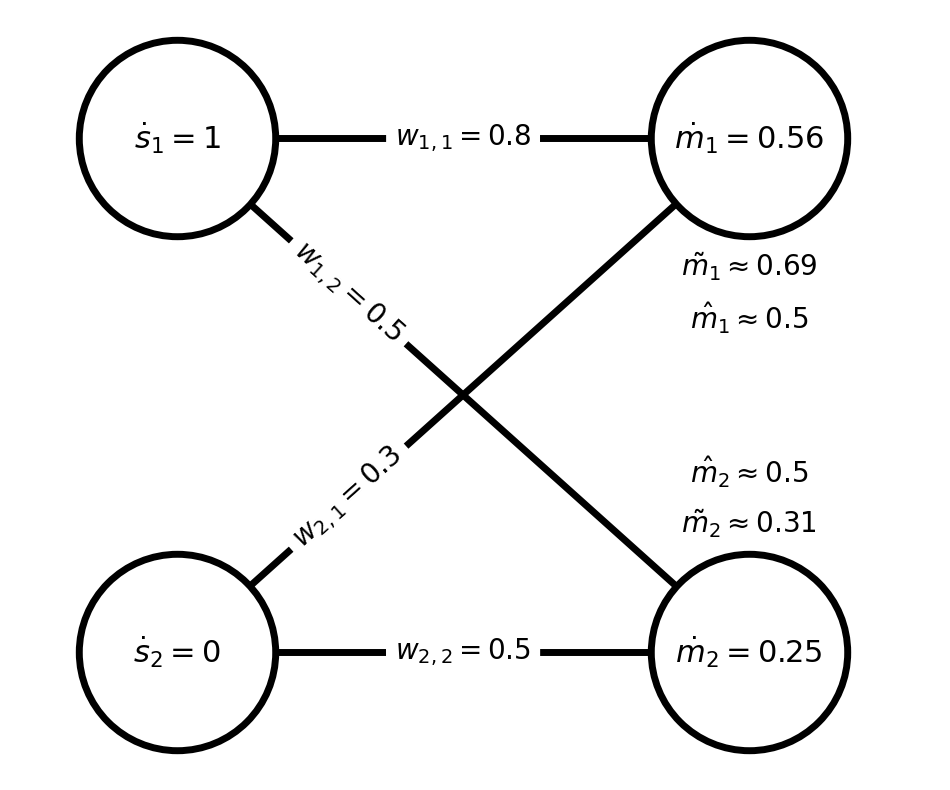

In [2]:
#Figure 1

# Create the bipartite graph
B_updated = nx.Graph()

# Define node labels
node_labels = {
    r"$\dot{s}_1=1$": r"$\dot{s}_1=1$",
    r"$\dot{s}_2=0$": r"$\dot{s}_2=0$",
    r"$\dot{m}_1=0.56$": r"$\dot{m}_1=0.56$",
    r"$\dot{m}_2=0.25$": r"$\dot{m}_2=0.25$",
}

# Add nodes to the graph
B_updated.add_nodes_from(node_labels.keys())

# Define edges with labels
edge_labels_corrected = {
    (r"$\dot{s}_1=1$", r"$\dot{m}_1=0.56$"): r"$w_{1,1} = 0.8$",
    (r"$\dot{s}_1=1$", r"$\dot{m}_2=0.25$"): r"$w_{1,2} = 0.5$",
    (r"$\dot{s}_2=0$", r"$\dot{m}_1=0.56$"): r"$w_{2,1} = 0.3$",
    (r"$\dot{s}_2=0$", r"$\dot{m}_2=0.25$"): r"$w_{2,2} = 0.5$",
}

# Add edges to graph
for u, v in edge_labels_corrected.keys():
    B_updated.add_edge(u, v)

# Define positions for nodes
adjusted_pos = {
    r"$\dot{s}_1=1$": (-1.2, 1),
    r"$\dot{s}_2=0$": (-1.2, -1),
    r"$\dot{m}_1=0.56$": (1.2, 1),
    r"$\dot{m}_2=0.25$": (1.2, -1),
}

# Plot the updated graph with adjusted arrow positions
plt.figure(figsize=(12, 10))

# Adjust plot limits for full visibility
plt.xlim(-1.9, 2)
plt.ylim(-1.5, 1.5)

# Reduce text sizes for better fit
node_font_size = 22
edge_label_font_size = 20

# Draw nodes and edges
nx.draw(
    B_updated, adjusted_pos, labels=node_labels, node_color="white", edge_color="black",
    node_size=20000, font_size=node_font_size, linewidths=5, edgecolors="black", width=5
)

# Draw edge labels
for (u, v), label in edge_labels_corrected.items():
    label_pos = 0.7  # Default label position
    if (u, v) == (r"$\dot{s}_1=1$", r"$\dot{m}_1=0.56$") or (u, v) == (r"$\dot{s}_2=0$", r"$\dot{m}_2=0.25$"):
        label_pos = 0.5  # Keep these at 0.5
    nx.draw_networkx_edge_labels(B_updated, adjusted_pos, edge_labels={(u, v): label}, font_size=edge_label_font_size, label_pos=label_pos)

# Update label values
plt.text(1.2, 0.5, r"$\tilde{m}_1 \approx 0.69$", fontsize=edge_label_font_size, ha="center", va="center")
plt.text(1.2, -0.5, r"$\tilde{m}_2 \approx 0.31$", fontsize=edge_label_font_size, ha="center", va="center")

# Add expectation labels
plt.text(1.2, 0.3, r"$\hat{m}_1 \approx 0.5$", fontsize=edge_label_font_size, ha="center", va="center")
plt.text(1.2, -0.3, r"$\hat{m}_2 \approx 0.5$", fontsize=edge_label_font_size, ha="center", va="center")

plt.show()

The prior probability of the two states in our mental model, $P(A)$, was given in the problem statement: 50% for each. We will notate the prior probability of the state represented in our mental model by a node $j$ as $\hat{m}_j$ and refer to it as the 'expectation'. To get the probability of our sensory state, $P(B)$, we simply need the sum of $P(B \mid A=j)P(A=j)$ for all nodes $j$ in our mental model. Thus

\begin{equation}
\tilde{m}_j = P(A=j \mid B) = \frac{P(B \mid A=j)P(A=j)}{P(B)} = \frac{\dot{m}_j\hat{m}_j}{\sum_{j'=1}^{\lvert M \rvert}\dot{m}_{j'}\hat{m}_{j'}},
\end{equation}

where $\tilde{m}_j$ is the activation of the node representing state $j$ in our mental model and $\lvert M \rvert$ is the number of states in our mental model. Note that that this operation is the same as normalizing the excitation-expectation-product across all mental model nodes.

Thus, we can describe the excitation of mental model nodes as a feed-forward operation on the Bayesian Network, parameterized by the prior probailities (i.e. expectation states) of the mental model nodes. This excitation gives the likelihood of the sensory state, given that the mental model node represents the true world state. We can then describe the activation state of a mental model node as the normalization of all mental model node excitations. Given that the Bayesian Graph is an accurate representation of the true world states, the activation state of a mental model node gives the probability that the node represents the true world state.


### Filtering using a Bayesian Network for State Estimation Given First Order Correlations In World State Sequences 

If the probabilities of transitioning from a given world state any other world state are known, the posterior probabilites of all states in the mental model can be used to determine prior probalities for those states in the future. For example, consider a simple case where it is known that coin flips alternate between the biased and unbiased states - as depicted in Figure 2. We can represent these transitions in a mental model by estblishing directed "clip edges" between mental model nodes (we will arrive at the reason for naming them "clip edges" later); if the weights of all clip edges that lead from one state in the mental model are normalized, they give the probability of transition from that state to the state to which the edge leads. Thus: given a set of posterior probabilities and a transtion model, the prior probability of the next state can be computed as

\begin{equation}
\hat{m}^{(t+1)}_{j'} = \sum_{j=1}^{\lvert M \rvert}\tilde{m}_j^{(t)} c_{jj'},
\end{equation}

where $c_{jj'}$ is the normalized clip edge weight from node $j$ to node $j'$ in the mental model. The forward propogation of variables in the resulting graph enables the Bayesian Network to integrate sensory evidence over time and reduce uncertainty regarding the true state. This process is known as Bayesian Filtering.

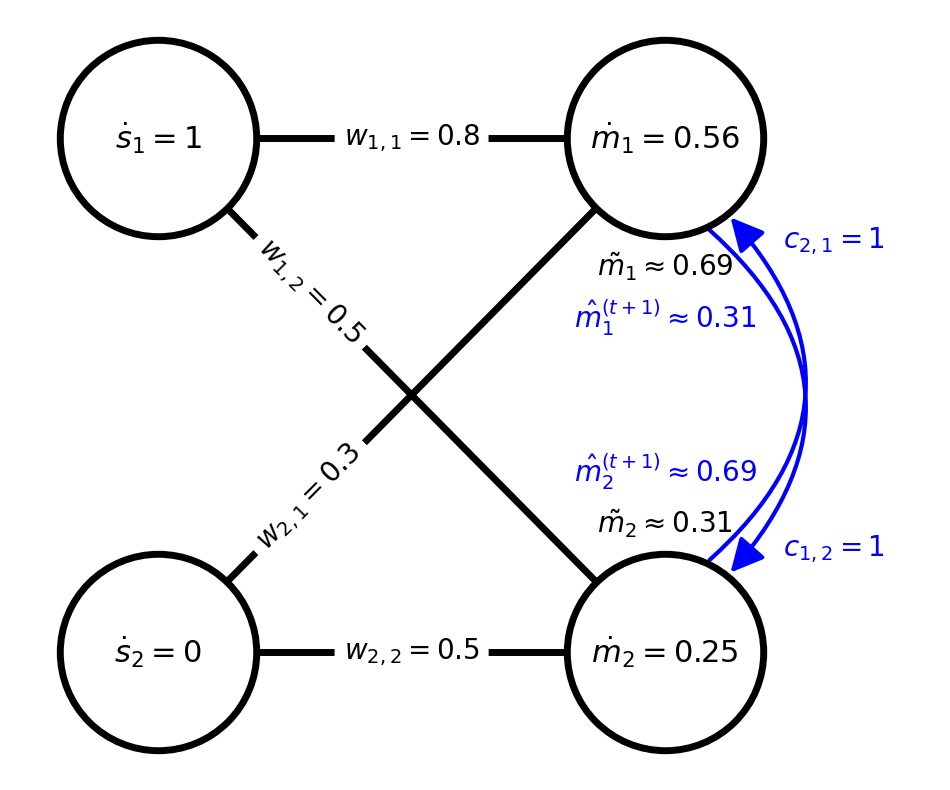

In [3]:
#Figure 2

# Create the bipartite graph
B_updated = nx.Graph()

# Define node labels
node_labels = {
    r"$\dot{s}_1=1$": r"$\dot{s}_1=1$",
    r"$\dot{s}_2=0$": r"$\dot{s}_2=0$",
    r"$\dot{m}_1=0.56$": r"$\dot{m}_1=0.56$",
    r"$\dot{m}_2=0.25$": r"$\dot{m}_2=0.25$",
}

# Add nodes to the graph
B_updated.add_nodes_from(node_labels.keys())

# Define edges with labels
edge_labels_corrected = {
    (r"$\dot{s}_1=1$", r"$\dot{m}_1=0.56$"): r"$w_{1,1} = 0.8$",
    (r"$\dot{s}_1=1$", r"$\dot{m}_2=0.25$"): r"$w_{1,2} = 0.5$",
    (r"$\dot{s}_2=0$", r"$\dot{m}_1=0.56$"): r"$w_{2,1} = 0.3$",
    (r"$\dot{s}_2=0$", r"$\dot{m}_2=0.25$"): r"$w_{2,2} = 0.5$",
}

# Add edges to graph
for u, v in edge_labels_corrected.keys():
    B_updated.add_edge(u, v)

# Define positions for nodes
adjusted_pos = {
    r"$\dot{s}_1=1$": (-1.2, 1),
    r"$\dot{s}_2=0$": (-1.2, -1),
    r"$\dot{m}_1=0.56$": (1.2, 1),
    r"$\dot{m}_2=0.25$": (1.2, -1),
}

# Plot the updated graph with adjusted arrow positions
plt.figure(figsize=(12, 10))

# Adjust plot limits for full visibility
plt.xlim(-1.9, 2.5)
plt.ylim(-1.5, 1.5)

# Reduce text sizes for better fit
node_font_size = 22
edge_label_font_size = 20

# Draw nodes and edges
nx.draw(
    B_updated, adjusted_pos, labels=node_labels, node_color="white", edge_color="black",
    node_size=20000, font_size=node_font_size, linewidths=5, edgecolors="black", width=5
)

# Draw edge labels
for (u, v), label in edge_labels_corrected.items():
    label_pos = 0.7  # Default label position
    if (u, v) == (r"$\dot{s}_1=1$", r"$\dot{m}_1=0.56$") or (u, v) == (r"$\dot{s}_2=0$", r"$\dot{m}_2=0.25$"):
        label_pos = 0.5  # Keep these at 0.5
    nx.draw_networkx_edge_labels(B_updated, adjusted_pos, edge_labels={(u, v): label}, font_size=edge_label_font_size, label_pos=label_pos)

# Update label values
plt.text(1.2, 0.5, r"$\tilde{m}_1 \approx 0.69$", fontsize=edge_label_font_size, ha="center", va="center")
plt.text(1.2, -0.5, r"$\tilde{m}_2 \approx 0.31$", fontsize=edge_label_font_size, ha="center", va="center")

# Manually add a curved directed edge with an explicit arrowhead at node borders
ax = plt.gca()

# First directed edge (m1 to m2)
arrow1 = FancyArrowPatch(
    (1.4, 0.65), (1.5, -0.7),
    connectionstyle="arc3,rad=-0.5",  # Strong rightward curve
    arrowstyle="-|>",  # Explicit arrowhead
    mutation_scale=50,  # Arrowhead size
    color="blue",
    linewidth=3
)

# Second directed edge (m2 to m1)
arrow2 = FancyArrowPatch(
    (1.4, -0.65), (1.5, 0.7), 
    connectionstyle="arc3,rad=0.5",  # Strong rightward curve
    arrowstyle="-|>",  # Explicit arrowhead
    mutation_scale=50,  # Arrowhead size
    color="blue",
    linewidth=3
)

ax.add_patch(arrow1)
ax.add_patch(arrow2)

# Position the directed edge labels
plt.text(2.0, -0.6, r"$c_{1,2} = 1$", fontsize=edge_label_font_size, ha="center", va="center", color="blue")
plt.text(2.0, 0.6, r"$c_{2,1} = 1$", fontsize=edge_label_font_size, ha="center", va="center", color="blue")

# Add expectation labels
plt.text(1.2, 0.3, r"$\hat{m}_1^{(t+1)} \approx 0.31$", fontsize=edge_label_font_size, ha="center", va="center", color = "blue")
plt.text(1.2, -0.3, r"$\hat{m}_2^{(t+1)} \approx 0.69$", fontsize=edge_label_font_size, ha="center", va="center", color = "blue")


# Show the final refined graph with correctly positioned arrows
plt.show()


Thus far, I have introduced a new notation for describing a neural-network-like implementation for Bayesian Filtering. Why? Embodied agents may face situations in which they do not already posses a mental model of the possible states, the probabilities of sensations in those states, and the transition probailities between states. Memory of previous sequences of sensations may serve as template models for the future state estimation, but an embodied agent must be capable of encoding those memories in a way that enables both Bayesian state estimation and the ability to learn which memories - and which aspects of those memories - are useful as models for future state estimation. We will now use the framework and notation established to show how a system of episodic memory encoding that follows the same principles as a Bayesian Network can usefully approximate a Fixed State Bayesian Network that accurately models the true world states, while creating a foundation upon which other learning processes can guide the mental model to accurately reflect complex systems in the world that the agent cannot directly observe.

### Replacing Fixed States with Episodic Memory Traces in a Bayesian Network

Let us now think of $m$ nodes in the mental model not as representing world states but as reprenting *episodic memories*; we will call them **memory traces**. We will assume for now that the agent has some number, $\lvert M \rvert$, memory traces available to it, and that prior to observing any sensory states all weights in the $\boldsymbol{W}$ matrix are 0.5 and all weights in $\boldsymbol{C}$ are $0$ (note: because the values in C are intialized at 0, it does not actually matter what values are used for W, except that the agent must always have at least one edge in this matrix that is greater than 0 or it will come to believe that the world does not exist and it will never recover. 0.5 is simply a nice number because it implies unencoded traces carry no information about the sensory state.) Now let us say that whenever the agent observes a new sensory state, it encodes that observation into its episodic memory by selecting a memory trace and adding weight to relevent edges connected to that trace. If we want the memory trace to represent exactly the state of the world when it was encoded, we could set the weight of edges connected to excited sensory elements to 1, and also set the weight of the clip edge that points from the last encoded trace to the being-encoded trace to 1. If we do this, however, the trace will only ever be activated if the agent has just observed the *exact* sequence of sensory states that preceded the being-encoded memory trace. 

What we want instead is for the memory trace to represent (or come to represent) the properties of the world state at the time the trace was encoded that are relevent to the agent's ability to predict it's future sensory states. There must therefore be some possibility that in the future the trace becomes activated even when the agent's curent history of sensory states does not match its history of sensory states at the time the trace was encoded. One way to do this is to set excitation weights to 1 if excited during encoding, but attenuate how strongly the excitation weights affects memory trace excitation in later time steps. This means new sensory evidence will have a weaker affect on trace activation, relative to prior expectation, but that strong expectation on a trace will still result in setting a strong expectation on the sensory state that followed encoded to it. Alternatively, we can attentuate the strength of clip weights between sequentially encoded traces, relative to clips weights that lead to other encoded traces. The leads to a more even distribution of expectation across memory, and a stronger role of new sensory evidence in determining trace activation.  

The key idea here is that the Bayesian Memory Network treats every memory trace as representing its own unique world state, from which a corresponding sensory state (and the sequence of past and future sensory states) can be fully determined. The activation state of a memory trace, however, does not represent the probability that the world is once again in that state (as in the Fixed State Bayesian Network), but the relative usefulness of that memory for understanding the current world state. The excitation input to a memory trace, then, does not exactly represent the likelihood of the sensory state given the current world state is the same as when the trace was encoded - it represents the likelihood that the trace will be useful for making predictions given (1) the similarity between the current and encoded sensory state and (2) an estimate of how strongly sensory evidence should influence beliefs about the current state. And the weight of the clip edges from a memory trace, rather than representing the probability of transitioning from one state to another, respresents the how useful the network believes the estimated similarity between an encoded trace and the current state is for predicting the future.

We have thus identified two *intrinsic biases* we can use to scale a Bayesian Network representation of a deterministic sequence of remembered events into a stochastic model of an unknown environment.

First, we can give a Bayesian network an intrinsic prior on the *average* amount of information that a sensory bit will carry regarding the world's *effective state* relative to the agent.  We implement this by performing a logistic transformation on excitatory edge weights before passing excitation input to the memory traces, where the **sensory evidence prior** is the scale parameter and the function midpoint is shifted to 0.5.  Thus, to get the excitation of memory traces in a Bayesian Memory Network we adjust Equation 1 to

\begin{equation}
\dot{m}_\mathrm{j} = \prod_{\mathrm{i} = 1}^{\lvert\boldsymbol{S}\rvert} f_\kappa(w_\mathrm{ij})^{\dot{s}_\mathrm{i}}(1-f_\kappa(w_\mathrm{ij}))^{1-\dot{s}_\mathrm{i}},
\end{equation}

where 

\begin{equation}
f_\kappa(x) = \frac{1}{1+\mathrm{e}^{-\kappa(x-0.5)}} 
\end{equation}

and $\kappa$ is the sensory evidence prior.

Second, we can give the Bayesian Memory Network an intrinsic prior on its ability to predict its next situation given its belief about the current situation. We call the the **continuity prior**, $\delta$, and implement it by setting the clip edge from the last encoded trace to the being encoded trace equal to this value and the clip edge for all other traces to the being encoded trace to $1 - \frac{\delta}{\lvert M \rvert - 1}$. In other words, \delta gives the proportion of a trace's activation (the network's estimate of that trace's relative usefulness for understanding its current situtation) that is passed as expectation to the trace that was encoded after it and the remainder of the activation is passed as expectation divided among the remaining *encoded* traces. (Note - this isn't quite accurate. Because clip weights are normalized over the encoded traces, the "remainder" of activation that would other wise go to unencoded traces gets redistributed evenly between both the next trace and the other encoded traces. I do not know how to explain this well/succinctly).

To avoid the scenario it which the excitation of a sensory element that has never been excited before causes infinite surprise, we do not assign weights on the excitation edges to a being-encoded trace to exactly the excitation of the sensory element they lead from, but to a number very close (eg. 0.99 if the element is excited, 0.01 otherwise). This is to avoid the scenario in which the failure to excite a sensory element that has always been excited causes the network infinite surprise.

Figure 3 shows the edge weights of such a Bayesian Memory Network after two observations - first a heads-up quarter and tails-up nickel, then both coins heads up.

Finally, encoding a memory trace sets its excitation to 0. This is because the network is excited prior to memory trace encoding and we do not want the activation of the network to reflect any information previously encoded the trace that has just been overwritten (and it is unhelpful - due to the lack of information about the future - for the network activation to be biased by the obvious fact that the just-encoded memory trace is a good represenation of the network's current effective state in the world).

In general, one might hypothesize that embodied agents in the real world would benefit from strong sensory evidence and continuity priors. Naturally, however, the best values for the priors are given by the effective randomness of sensory evidence by and the effective randomness of knowable states, respectively (note: the don't think the descriptions of these "true" values are quite right. Needs some thought). This will be demonstrated in our simulations.



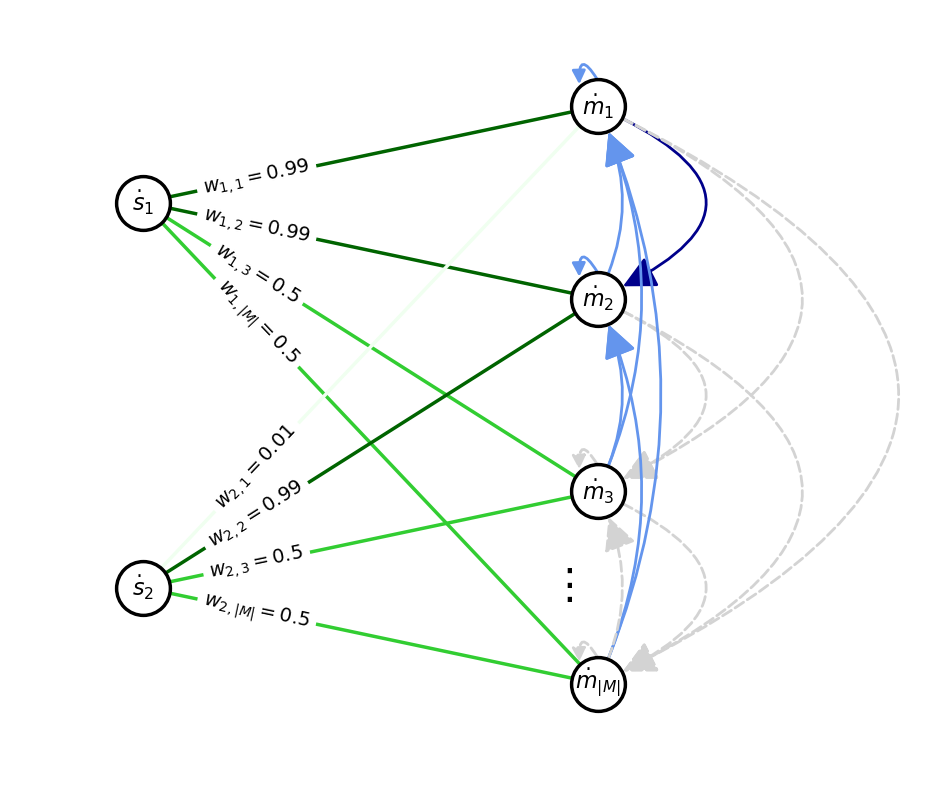

In [66]:
#Figure 3

# Create a new bipartite graph with additional nodes
B_new = nx.Graph()

# Define new node labels
node_labels_new = {
    r"$\dot{s}_1$": r"$\dot{s}_1$",
    r"$\dot{s}_2$": r"$\dot{s}_2$",
    r"$\dot{m}_1$": r"$\dot{m}_1$",
    r"$\dot{m}_2$": r"$\dot{m}_2$",
    r"$\dot{m}_3$": r"$\dot{m}_3$",
    r"$\dot{m}_{|M|}$": r"$\dot{m}_{|M|}$",  # Separated node
}

# Add nodes to the graph
B_new.add_nodes_from(node_labels_new.keys())

# Define positions for the nodes
adjusted_pos_new = {
    r"$\dot{s}_1$": (-1.2, 1),
    r"$\dot{s}_2$": (-1.2, -1),
    r"$\dot{m}_1$": (1.2, 1.5),
    r"$\dot{m}_2$": (1.2, 0.5),
    r"$\dot{m}_3$": (1.2, -0.5),
    r"$\dot{m}_{|M|}$": (1.2, -1.5),  # Aligned node
}

# Define edges connecting each s-node to each m-node
edges_new = [
    (s, m) for s in [r"$\dot{s}_1$", r"$\dot{s}_2$"] for m in [r"$\dot{m}_1$", r"$\dot{m}_2$", r"$\dot{m}_3$", r"$\dot{m}_{|M|}$"]
]
B_new.add_edges_from(edges_new)

# Define edge labels following the given format
edge_labels_new = {
    (r"$\dot{s}_1$", r"$\dot{m}_1$"): r"$w_{1,1} = 0.99$",
    (r"$\dot{s}_1$", r"$\dot{m}_2$"): r"$w_{1,2} = 0.99$",
    (r"$\dot{s}_1$", r"$\dot{m}_3$"): r"$w_{1,3} = 0.5$",
    (r"$\dot{s}_1$", r"$\dot{m}_{|M|}$"): r"$w_{1,|M|} = 0.5$",
    (r"$\dot{s}_2$", r"$\dot{m}_1$"): r"$w_{2,1} = 0.01$",
    (r"$\dot{s}_2$", r"$\dot{m}_2$"): r"$w_{2,2} = 0.99$",
    (r"$\dot{s}_2$", r"$\dot{m}_3$"): r"$w_{2,3} = 0.5$",
    (r"$\dot{s}_2$", r"$\dot{m}_{|M|}$"): r"$w_{2,|M|} = 0.5$",
}

w_edge_colors = {
    (r"$\dot{s}_1$", r"$\dot{m}_1$"): "darkgreen",
    (r"$\dot{s}_1$", r"$\dot{m}_2$"): "darkgreen",
    (r"$\dot{s}_1$", r"$\dot{m}_3$"): "limegreen",
    (r"$\dot{s}_1$", r"$\dot{m}_{|M|}$"): "limegreen",
    (r"$\dot{s}_2$", r"$\dot{m}_1$"): "honeydew",
    (r"$\dot{s}_2$", r"$\dot{m}_2$"): "darkgreen",
    (r"$\dot{s}_2$", r"$\dot{m}_3$"): "limegreen",
    (r"$\dot{s}_2$", r"$\dot{m}_{|M|}$"): "limegreen",
}
# Define directed edges among m-nodes (including self-loops)
directed_edges = [(start,end) for start in node_labels_new.keys() if 'm' in start for end in node_labels_new.keys() if 'm' in end]

# Plot the updated graph with directed m-to-m edges
plt.figure(figsize=(12, 10))

# Adjust plot limits for full visibility
plt.xlim(-1.9, 3.0)
plt.ylim(-2.0, 2.0)

# Reduce text sizes for better fit
node_font_size = 16
edge_label_font_size = 14
node_size_smaller = 1500  # Smaller nodes

# Draw nodes and edges
nx.draw(
    B_new, adjusted_pos_new, labels=node_labels_new, node_color="white", edge_color=w_edge_colors.values(),
    node_size=node_size_smaller, font_size=node_font_size, linewidths=2.5, edgecolors = "black", width=2.5
)

# Draw existing edge labels
nx.draw_networkx_edge_labels(B_new, adjusted_pos_new, edge_labels=edge_labels_new, font_size=edge_label_font_size, label_pos=0.75)

# Draw curved directed edges among m-nodes with explicit arrows
ax = plt.gca()
def adjust_curved_edge_positions(start, end, radius, rad):
    """Adjusts edge positions for curved edges to terminate at node borders."""
    midpoint = (np.array(start) + np.array(end)) / 2
    curve_offset = np.array([(end[1] - start[1]), end[0] - start[0]]) * rad  # Offset perpendicular to the edge
    curved_midpoint = midpoint + curve_offset  # Apply curvature offset
    
    direction_start = curved_midpoint - np.array(start)
    direction_start = direction_start / np.linalg.norm(direction_start)  # Normalize
    new_start = np.array(start) + direction_start * radius
    
    direction_end = curved_midpoint - np.array(end)
    direction_end = direction_end / np.linalg.norm(direction_end)  # Normalize
    new_end = np.array(end) + direction_end * radius
    
    return new_start, new_end
# Compute node radius to adjust edge positions
node_radius = 0.13  # Approximate node radius in plot coordinates (assessed by trial and error)

for i, (u, v) in enumerate(directed_edges):
    linestyle = 'solid'
    if u == r"$\dot{m}_1$" and v == r"$\dot{m}_2$":
        color = "darkblue"
    elif v in [r"$\dot{m}_1$",r"$\dot{m}_2$"]:
        color = "cornflowerblue"
    else:
        color = "lightgrey"
        linestyle = 'dashed'
    if u == v:  # Self-loop case
        arrow = FancyArrowPatch(
            np.array(adjusted_pos_new[u]) + np.array((0,node_radius)), np.array(adjusted_pos_new[v]) + np.array((-0.10,0.1)),
            connectionstyle="arc3,rad=2",  # Small loop for visibility
            arrowstyle="-|>",
            mutation_scale=20,
            color=color,
            linestyle = linestyle,
            linewidth=2
        )
    else:
        rad = 0.2 if u > v else -1
        start_pos, end_pos = adjust_curved_edge_positions(adjusted_pos_new[u], adjusted_pos_new[v], node_radius, rad)
        arrow = FancyArrowPatch(
            start_pos, end_pos,
            connectionstyle=f"arc3,rad={rad}",
            arrowstyle="-|>",  # Explicit arrowhead
            mutation_scale=50,  # Arrowhead size
            color=color,
            linestyle = linestyle,
            linewidth=2
        )
    ax.add_patch(arrow)

# Draw ellipses to indicate continuation between nodes
plt.text(1.0, -1.0, r"$\vdots$", fontsize=30, ha="center", va="center")  # Vertical ellipses

# Show the updated graph with smaller nodes and directed edges with arrows
plt.show()

### Testing the Bayesian Memory Network

In order to assess how well the Bayesian Memory Network does at state estimation, relative to an accurate fixed state Bayesian network, we can use the surprise generated by the networks' expectations. To do this, we must first get expectations for each sensory node. This can be achieved by feeding the expectation of memory/model nodes back to the sensory elements along connected edges, i.e. 

\begin{equation}
\hat{s}_i = \sum_{j=1}^{\lvert M \rvert} \hat{m}_j w_{ij}
\end{equation}

Having thus defined $\hat{s}_i$ as the prior probality that node $s_i$ is excited, we can define the surprise for a single sensory element as

\begin{equation}
\mathrm{I}(s_\mathrm{i}) = 
\left\{
\begin{array}{ll}
  -\mathrm{log}_2(\hat{s}_\mathrm{i}) & \text{if } \dot{s}_\mathrm{i} = 1  \\
  -\mathrm{log}_2(1-\hat{s}_\mathrm{i}) & \text{if } \dot{s}_\mathrm{i} = 0.
\end{array}
\right.
\end{equation}

We can then define the total surprise of the network as $\mathrm{I}(\boldsymbol{s}) = \sum_{i=1}^{\lvert S \rvert} \mathrm{I}(s_i)$.


#### Fixed State Bayesian Network Baselines

Lets look at how the surprise of the two types of Bayesian Networks changes as they observe coin flips in the alternating bias scenario described. We will create and test the fixed state network first.

In [5]:
class Bayesian_Network:
    def __init__(self, num_sensory_elements, num_m_nodes, W_matrix, C_matrix, m_expectation = None):
        self.num_sensory_elements = num_sensory_elements
        self.num_m_nodes = num_m_nodes
        self.W_matrix = W_matrix  # Shape: (num_sensory_elements, num_m_nodes)
        self.C_matrix = C_matrix  # Shape: (num_m_nodes, num_m_nodes)
        
        # Initialize sensory and m-level variables as empty numpy arrays
        self.sensory_excitation = np.empty(num_sensory_elements)
        self.m_excitation = np.empty(num_m_nodes)
        self.m_expectation = np.full(num_m_nodes, fill_value = 1/num_m_nodes) if m_expectation is None else m_expectation
        self.sensory_expectation = np.dot(self.m_expectation, self.W_matrix.T)
        self.m_activation = np.empty(num_m_nodes)
    
    def excite_network(self, percept):
        """Set the sensory excitation and compute m_excitation."""
        if percept.shape[0] != self.num_sensory_elements:
            raise ValueError("Percept vector size does not match the number of sensory elements.")
        
        self.sensory_excitation = percept  # Set sensory excitation
        
        # Compute m_excitation using equation 1
        self.m_excitation = np.prod(
            np.power(self.W_matrix, self.sensory_excitation[:, np.newaxis]) * 
            np.power(1 - self.W_matrix, (1 - self.sensory_excitation)[:, np.newaxis]),
            axis=0
        )
    
    def activate(self):
        """Compute m_activation based on m_excitation and m_expectation."""
        numerator = self.m_excitation * self.m_expectation
        denominator = np.sum(numerator)
        
        if denominator == 0:
            self.m_activation = np.zeros(self.num_m_nodes)  # Avoid division by zero (network properties are such that this should never happen)
        else:
            self.m_activation = numerator / denominator
    
    def set_expectations(self):
        """Set m_expectation and sensory_expectation based on activation and weight matrices."""
        
        # Normalize C_matrix rows to ensure proper probability distributions
        row_sums = self.C_matrix.sum(axis=1, keepdims=True)
        normalized_C_matrix = np.divide(self.C_matrix, row_sums, where=row_sums!=0)
        
        # Compute m_expectation using the normalized C_matrix
        self.m_expectation = np.dot(self.m_activation, normalized_C_matrix)
        
        # Compute sensory_expectation using W_matrix
        self.sensory_expectation = np.dot(self.m_expectation, self.W_matrix.T)

    def get_surprise(self):
        """Compute the total surprise of the network."""
        
        # Compute individual sensory surprise values
        surprise_values = np.where(
            self.sensory_excitation == 1,
            -np.log2(self.sensory_expectation),
            -np.log2(1 - self.sensory_expectation)
        )
        
        # Sum all sensory surprises to get total surprise
        total_surprise = np.sum(surprise_values)
        
        return total_surprise

We can run a few steps manually to double check that everything works as described

In [6]:
#create network
fixed_state = Bayesian_Network(num_sensory_elements=2, num_m_nodes=2, W_matrix = np.array(([0.8,0.5],[0.3,0.5])), C_matrix = np.array(([0,1],[1,0])))

#step 1
#1a. Excite Network
fixed_state.excite_network(np.array((1,0)))
print("m_excitation = " + str(fixed_state.m_excitation))
print("surprise = " + str(fixed_state.get_surprise()))

m_excitation = [0.56 0.25]
surprise = 1.3584539709124763


In [7]:
#1b. Activate m-nodes
fixed_state.activate()
print("m_activate = " + str(fixed_state.m_activation))

m_activate = [0.69135802 0.30864198]


In [8]:
#1c. Predict (Get prior proabilities/expectations for next step)
fixed_state.set_expectations()
print("new m_expectation = " + str(fixed_state.m_expectation))
print("new sensory_expectation = " + str(fixed_state.sensory_expectation))

new m_expectation = [0.30864198 0.69135802]
new sensory_expectation = [0.59259259 0.4382716 ]


In [9]:
#step 2
#a. Excite
fixed_state.excite_network(np.array((1,1)))
print("m_excitation = " + str(fixed_state.m_excitation))
print("surprise = " + str(fixed_state.get_surprise()))
#b. Activate
fixed_state.activate()
print("m_activate = " + str(fixed_state.m_activation))
#c. Predict
fixed_state.set_expectations()
print("new m_expectation = " + str(fixed_state.m_expectation))
print("new sensory_expectation = " + str(fixed_state.sensory_expectation))

m_excitation = [0.24 0.25]
surprise = 1.9449903855434114
m_activate = [0.3 0.7]
new m_expectation = [0.7 0.3]
new sensory_expectation = [0.71 0.36]


Having confirmed that the code works as intended, let's run some random simulations. First, we can create a class that defines the coin-flip environment

In [10]:
class flip_generator:
    def __init__(self, probabilities, transitions, state):
        """
        Initialize the flip generator.
        :param probabilities: NxD numpy array of probabilities for generating binary vectors. N gives the number of coins/bits and D the number of system states
        :param transitions: DxD numpy array representing state transition probabilities.
        :param state: Integer representing the initial state.
        """
        self.probabilities = probabilities
        self.transitions = transitions
        self.state = state
        self.D, self.N = probabilities.shape  # Number of states (D) and vector length (N)
        
        # Assertions to ensure correct dimensionality
        assert transitions.shape == (self.D, self.D), "Transitions matrix must be DxD."
        assert probabilities.shape[1] == transitions.shape[1], "Probabilities and transitions must have the same number of states (D)."
        assert np.allclose(transitions.sum(axis=1), 1), "Each row of the transition matrix must sum to 1."
    
    def generate(self):
        """
        Generate a binary vector based on the current state and transition probabilities.
        :return: Generated binary array (1D numpy array of length N)
        """
        # Generate a binary vector where each element is 1 with probability P_{i, j}
        binary_array = np.random.rand(self.N) < self.probabilities[:,self.state]
        
        # Sample the next state from the transition probabilities
        self.state = np.random.choice(self.D, p=self.transitions[self.state])
        
        return binary_array

In [11]:
alternating_either_or = flip_generator(probabilities = np.array(([1,0],[0,1])), transitions = np.array(([0,1],[1,0])), state = 0)
print(alternating_either_or.state)
print(alternating_either_or.generate())
print(alternating_either_or.state)
print(alternating_either_or.generate())
print(alternating_either_or.state)
print(alternating_either_or.generate())

0
[ True False]
1
[False  True]
0
[ True False]


Then run simulations

In [12]:
#Set up Variables
N = 1000 
T = 50 
num_sensory_elements = 2
num_m_nodes = 2
W_matrix = np.array(([0.8,0.5],[0.3,0.5])) 
C_matrix = np.array(([0,1],[1,0]))
probabilities = np.array(([0.8,0.5],[0.3,0.5]))
transitions = np.array(([0,1],[1,0]))
env_state = 0
"""
Run N simulations for T iterations, storing the surprise values and expectations.
"""
surprise_data_BN = np.zeros((N, T))
m_expectations_BN = np.zeros((N,T,2))
sensory_expectations_BN = np.zeros((N,T,2))

for n in range(N):
    # Initialize Bayesian Network and Flip Generator for each simulation
    bayesian_net = Bayesian_Network(num_sensory_elements, num_m_nodes, W_matrix, C_matrix)
    flip_gen = flip_generator(probabilities, transitions, env_state)
    
    for t in range(T):
        # Generate percept input using flip generator
        percept = flip_gen.generate()
        
        #store expectations
        m_expectations_BN[n,t,:] = bayesian_net.m_expectation
        sensory_expectations_BN[n,t,:] = bayesian_net.sensory_expectation
        #excite
        bayesian_net.excite_network(percept)
        #store surprise
        surprise_data_BN[n, t] = bayesian_net.get_surprise()
        #activate
        bayesian_net.activate()
        #predict
        bayesian_net.set_expectations()
        

We can visualize the mean surprise of the simulated Bayesian Networks at each time step to get a sense of how well they make predictions. The solid horizontal lines indicate the entropy of observations in the baised and fair states - they represent the best an agent can do on average when predicting the results of flips in that state. Note that lower surprise means better predictions.

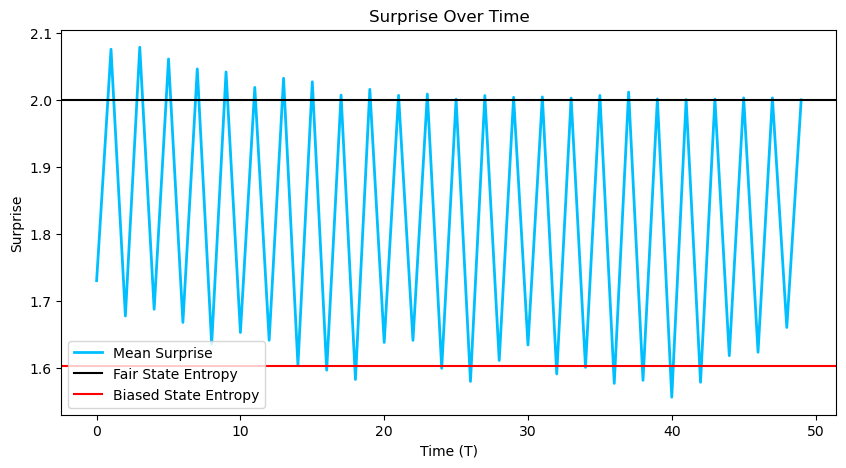

In [67]:
"""
Plot the mean surprise over time and 10 randomly selected simulations.
"""
T = surprise_data_BN.shape[1]
mean_surprise = np.mean(surprise_data_BN, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(range(T), mean_surprise, label='Mean Surprise', linewidth=2, color='deepskyblue')
biased_coin_entropy = -(0.8 * np.log2(0.8) + 0.2 * np.log2(0.2)) - (0.3 * np.log2(0.3) + 0.7 * np.log2(0.7))
plt.axhline(y = 2, label = "Fair State Entropy", linestyle = "solid", color = 'black')
plt.axhline(y = biased_coin_entropy, label = "Biased State Entropy", linestyle = "solid", color = 'red')

plt.xlabel("Time (T)")
plt.ylabel("Surprise")
plt.title("Surprise Over Time")
plt.legend(loc = 3)
plt.show()

From the plot above, it can be seen that the average surprise of the network when in both the biased and fair states approaches the true entropy of those states. If we look at the expectations of a sample network over time we can see how this result emerges from the convergence of m_expectation onto the correct representation of the world state.

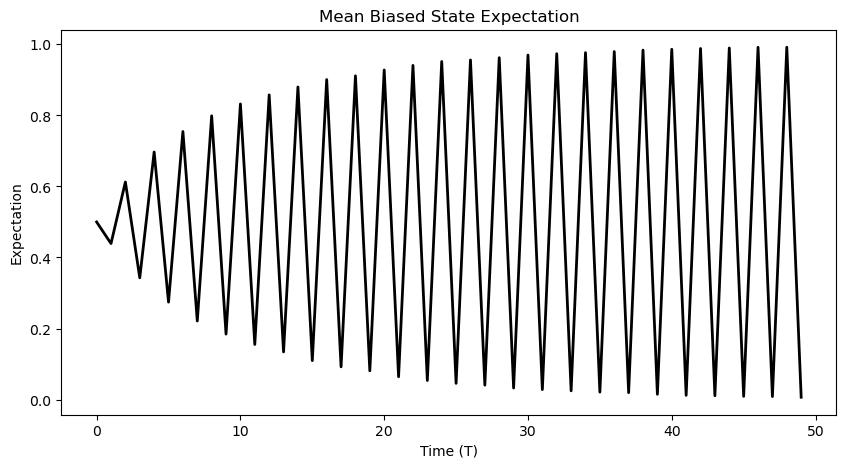

In [14]:
"""
Plot the mean biased state expectation over time
"""
T = surprise_data_BN.shape[1]
mean_expectation = np.mean(m_expectations_BN[:,:,0], axis = 0) #0 index on 3rd dimension gives the biased state

plt.figure(figsize=(10, 5))
plt.plot(range(T), mean_expectation, linewidth=2, color='black')
plt.xlabel("Time (T)")
plt.ylabel("Expectation")
plt.title("Mean Biased State Expectation")
plt.show()

So. The Bayesian Network successfully performs state estimation via Bayesian Filtering. What happens when we have no prior model of the environment and attempt to build one using the Bayesian Memory Network? Lets start by making a Bayesian Memory subclass of our Bayesian Network that has the different inital W_matrix and C_matrix and a method for updating these matrices as described by memory encoding. For now, we will use an internal timer to select nodes for encoding as memory traces.

In [15]:
class Bayesian_Memory(Bayesian_Network):
    def __init__(self, num_sensory_elements, num_m_nodes, W_matrix=None, C_matrix=None, timer=0, sensory_evidence_prior = 1, continuity_prior = 0.95):
        """
        Initialize the Bayesian Memory network.
        :param num_sensory_elements: Number of sensory elements.
        :param num_m_nodes: Number of memory nodes.
        :param W_matrix: Sensory to memory weight matrix, defaults to 0.5 for all weights if None.
        :param C_matrix: Memory transition matrix, defaults to zeros if None.
        :param timer: Integer tracking memory time index, defaults to 0.
        """
        if W_matrix is None:
            W_matrix = np.full((num_sensory_elements, num_m_nodes), fill_value = 0.5)
        if C_matrix is None:
            C_matrix = np.zeros((num_m_nodes, num_m_nodes))
        
        super().__init__(num_sensory_elements, num_m_nodes, W_matrix, C_matrix)
        self.timer = timer
        self.sensory_evidence_prior = sensory_evidence_prior
        self.continuity_prior = continuity_prior
    
    def encode_memory(self):
        """Modify W_matrix and C_matrix to encode sensory input into memory."""
        
        # Update W_matrix based on sensory excitation
        self.W_matrix[:, self.timer] = np.where(
            self.sensory_excitation == 1, 0.99 , 0.01
        )
        
        # Update C_matrix based on memory trace
        trace = self.timer
        self.C_matrix[:, trace] = (1 - self.continuity_prior) / (self.num_m_nodes - 1) #keeps wieghts normalized by default
        self.C_matrix[trace - 1, trace] = self.continuity_prior

        #remove excitation from encoded trace
        self.m_excitation[trace] = 0

        self.timer = (self.timer + 1) % self.num_m_nodes

    def excite_network(self, percept):
        """Set the sensory excitation and compute m_excitation."""
        if percept.shape[0] != self.num_sensory_elements:
            raise ValueError("Percept vector size does not match the number of sensory elements.")
        
        self.sensory_excitation = percept  # Set sensory excitation

        weighted_evidence = transforms._logistic(self.W_matrix, x_shift = 0.5, k = self.sensory_evidence_prior)
        # Compute m_excitation using equation 1
        self.m_excitation = np.prod(
            np.power(weighted_evidence, self.sensory_excitation[:, np.newaxis]) *  #changed from the Bayesian Network to apply logistic function
            np.power(1 - weighted_evidence, (1 - self.sensory_excitation)[:, np.newaxis]),
            axis=0
        )

Then lets run an instance for a few steps using the percepts given in our example to observe the network dynamics and ensure it works as described

In [16]:
#step 1
#a. Excite and Encode
episodic_memory = Bayesian_Memory(2,50)
episodic_memory.excite_network(np.array([1,0]))
episodic_memory.encode_memory()
episodic_memory.W_matrix

array([[0.99, 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
        0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
        0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
        0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
        0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ],
       [0.01, 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
        0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
        0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
        0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
        0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ]])

In [17]:
episodic_memory.m_excitation

array([0.  , 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25])

In [18]:
np.round(episodic_memory.C_matrix, decimals = 3)

array([[0.001, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.001, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.001, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.001, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.001, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.95 , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

In [19]:
#b. Activate
episodic_memory.activate()
episodic_memory.m_activation

array([0.        , 0.02040816, 0.02040816, 0.02040816, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816])

In [20]:
#c. Predict
episodic_memory.set_expectations()
episodic_memory.m_expectation

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [21]:
#Step 2
#a. Excite and Encode
episodic_memory.excite_network(np.array([1,1]))
episodic_memory.encode_memory()
print(episodic_memory.W_matrix)

[[0.99 0.99 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
 [0.01 0.99 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]]


In [22]:
print(episodic_memory.m_excitation)

[0.23557444 0.         0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25      ]


In [23]:
print(np.round(episodic_memory.C_matrix, decimals = 3))

[[0.001 0.95  0.    ... 0.    0.    0.   ]
 [0.001 0.001 0.    ... 0.    0.    0.   ]
 [0.001 0.001 0.    ... 0.    0.    0.   ]
 ...
 [0.001 0.001 0.    ... 0.    0.    0.   ]
 [0.001 0.001 0.    ... 0.    0.    0.   ]
 [0.95  0.001 0.    ... 0.    0.    0.   ]]


In [24]:
#b. Activate
episodic_memory.activate()
print(episodic_memory.m_activation)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [25]:
#c. Predict
episodic_memory.set_expectations()
episodic_memory.m_expectation

array([0.00107296, 0.99892704, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [26]:
#Step 3
#a. Excite and Encode
episodic_memory.excite_network(np.array([1,0]))
episodic_memory.encode_memory()
print(episodic_memory.W_matrix)

[[0.99 0.99 0.99 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
 [0.01 0.99 0.01 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]]


In [27]:
print(episodic_memory.m_excitation)

[0.38453199 0.23557444 0.         0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25      ]


In [28]:
#b. Activate
episodic_memory.activate()
print(episodic_memory.m_activation)

[0.00175022 0.99824978 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [29]:
#c. Predict
episodic_memory.set_expectations()
print(episodic_memory.m_expectation)

[0.00107181 0.00281641 0.99611178 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


As we can see, the dynamics of the Bayesian Memory Network are fairly complex. Let's run some simulations to get a better sense of how this network operates. We will look at simulations using a range of sensory evidence and continuity priors. These values have been selected from a larger set of simulations to give a good overview of patterns in the interactions of these two parameters.


In [30]:
#Set up Variables
N = 200
T = 200
sensory_evidence_priors = (0.4,0.5,0.7,1,1.5,2)
continuity_priors = (0.5,0.8, 0.9, 0.93, 0.96, 0.98, 0.99)
num_sensory_elements = 2
num_m_nodes = 100
probabilities = np.array(([0.8,0.5],[0.3,0.5]))
transitions = np.array(([0,1],[1,0]))
env_state = 0
"""
Run N simulations for T iterations, storing the surprise values and m_expectations.
"""
surprise_data_MN = np.zeros((len(sensory_evidence_priors), len(continuity_priors), N, T))
m_expectations_MN = np.zeros((len(sensory_evidence_priors), len(continuity_priors),N,T,num_m_nodes))
sensory_expectations_MN = np.zeros((len(sensory_evidence_priors), len(continuity_priors),N,T,num_sensory_elements))

for i in range(len(sensory_evidence_priors)):
    for j in range(len(continuity_priors)):
        for n in range(N):
            # Initialize Bayesian Network and Flip Generator for each simulation
            memory_net = Bayesian_Memory(num_sensory_elements, num_m_nodes, sensory_evidence_prior = sensory_evidence_priors[i], continuity_prior = continuity_priors[j])
            flip_gen = flip_generator(probabilities, transitions, env_state)
            
            for t in range(T):
                # Generate percept input using flip generator
                percept = flip_gen.generate()
                
                # Run Bayesian network methods in sequence
                m_expectations_MN[i,j,n,t,:] = memory_net.m_expectation
                sensory_expectations_MN[i,j,n,t,:] = memory_net.sensory_expectation
                memory_net.excite_network(percept)
                memory_net.encode_memory()
                surprise_data_MN[i,j,n,t] = memory_net.get_surprise()
                memory_net.activate()
                memory_net.set_expectations()
                

Let's look at the surprise over time for a single simulation first to get a sense of the data. In addition to the true entropy for each state, we also plot horizontal lines for the expected surprise of an agent that models the environment using a single state, i.e. it always expects the coins to be heads up in euqal proportion to the average rate across both states. Ideally, we want the Bayesian Memory network to make better predictions than this model, indicating that the structure of the network provides and exploits more information that a simple sampling of observations.

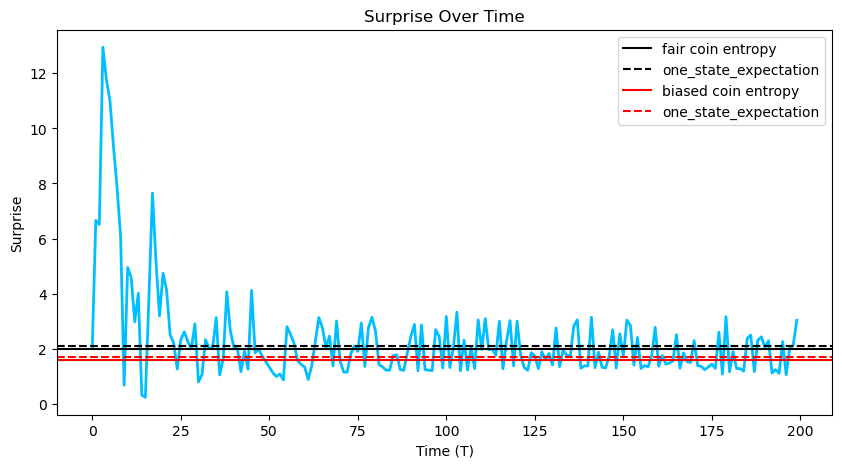

In [62]:
"""
Plot the surprise over time.
"""
T = surprise_data_MN.shape[3]
example_surprise = surprise_data_MN[2,2,0,:] #look at some some intermediate parameters first

plt.figure(figsize=(10, 5))
plt.plot(range(T), example_surprise, linewidth=2, color='deepskyblue')
biased_coin_entropy = -(0.8 * np.log2(0.8) + 0.2 * np.log2(0.2)) - (0.3 * np.log2(0.3) + 0.7 * np.log2(0.7))
one_state_surprise_bias = -(0.8 * np.log2(0.65) + 0.2 * np.log2(0.35)) - (0.3 * np.log2(0.4) + 0.7 * np.log2(0.6))
one_state_surprise_fair = -(0.5 * np.log2(0.65) + 0.5 * np.log2(0.35)) - (0.5 * np.log2(0.4) + 0.5 * np.log2(0.6))
plt.axhline(y = 2, label = "fair coin entropy", linestyle = "solid", color = 'black')
plt.axhline(y = one_state_surprise_fair, label = "one_state_expectation", linestyle = "dashed", color = 'black')
plt.axhline(y = biased_coin_entropy, label = "biased coin entropy", linestyle = "solid", color = 'red')
plt.axhline(y = one_state_surprise_bias, label = "one_state_expectation", linestyle = "dashed", color = 'red')
plt.xlabel("Time (T)")
plt.ylabel("Surprise")
plt.title("Surprise Over Time")
plt.legend()
plt.show()

We can see there is a fair amount of stochasticity in the surprise, which is to be expected: the environment is structured enough that the agent can set non-uniform expectations, but stochastic enough that those expectations will be defied regularly. Nonetheless, after a period of sampling the network's surprise appears to fluctuate around expected values given the true entropy, or at least the expectations given a single state model of the environment. Now lets look at the same plot, but averaging the surprise over all simulations. To get a better sense of how well the predictions are working, we can plot the average surprise at each time step over all simulations using the same intrinsic priors.

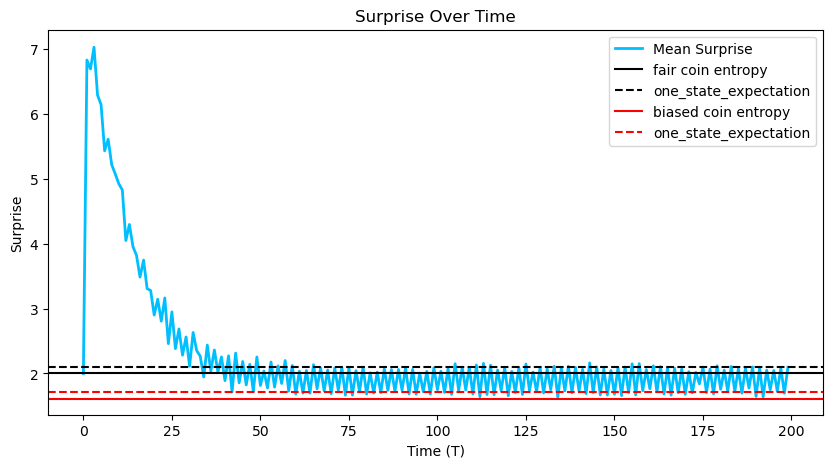

In [60]:
"""
Plot the mean surprise over time.
"""
T = surprise_data_MN.shape[3]
mean_surprise = np.mean(surprise_data_MN[2,2,:,:], axis=0) #look at some some intermediate parameters first

plt.figure(figsize=(10, 5))
plt.plot(range(T), mean_surprise, label='Mean Surprise', linewidth=2, color='deepskyblue')
biased_coin_entropy = -(0.8 * np.log2(0.8) + 0.2 * np.log2(0.2)) - (0.3 * np.log2(0.3) + 0.7 * np.log2(0.7))
one_state_surprise_bias = -(0.8 * np.log2(0.65) + 0.2 * np.log2(0.35)) - (0.3 * np.log2(0.4) + 0.7 * np.log2(0.6))
one_state_surprise_fair = -(0.5 * np.log2(0.65) + 0.5 * np.log2(0.35)) - (0.5 * np.log2(0.4) + 0.5 * np.log2(0.6))
plt.axhline(y = 2, label = "fair coin entropy", linestyle = "solid", color = 'black')
plt.axhline(y = one_state_surprise_fair, label = "one_state_expectation", linestyle = "dashed", color = 'black')
plt.axhline(y = biased_coin_entropy, label = "biased coin entropy", linestyle = "solid", color = 'red')
plt.axhline(y = one_state_surprise_bias, label = "one_state_expectation", linestyle = "dashed", color = 'red')
plt.xlabel("Time (T)")
plt.ylabel("Surprise")
plt.title("Surprise Over Time")
plt.legend()
plt.show()

On average, it looks like the network surprise falls between the true entropy of the state it is in and the expected surprise given a single state model: exactly what we want. Now tthat we have a sense of what the data look like over time, we can create some visual summaries of the simulation data when using different intrinsic priors. The following box plot takes the average surprise of each network in the biased and fair states for the latter 100 steps of each simulation (meaning 50 data points for each state for each simulation). The boxes, then, show the spread of these averages over all simulations given a particular set of intrinsic priors.

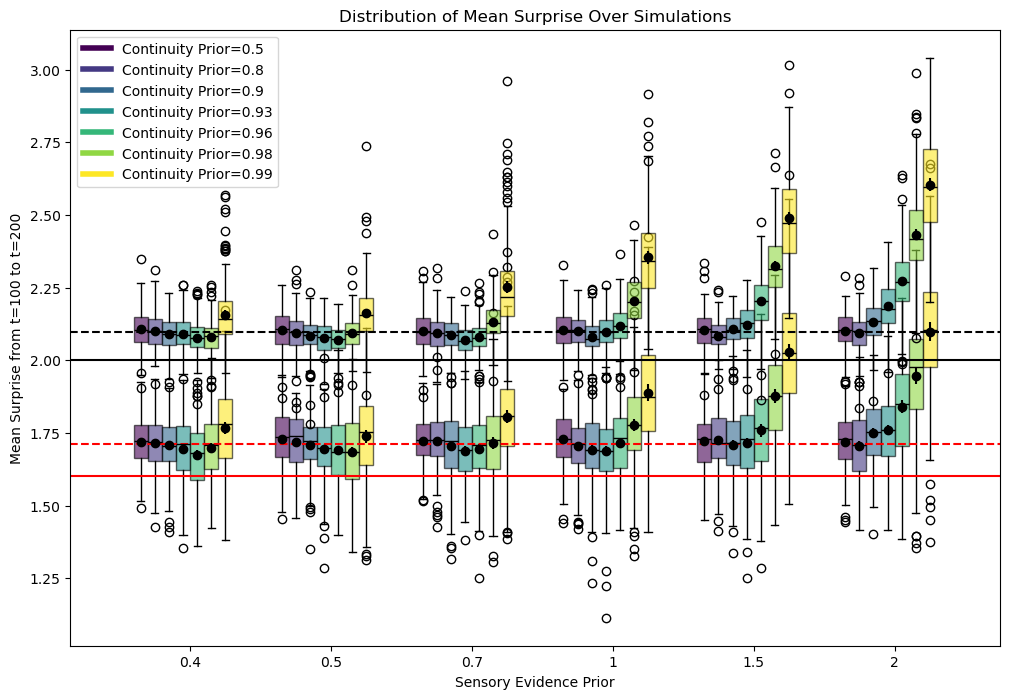

In [34]:
mean_biased_state_surprise = np.mean(surprise_data_MN[:,:,:,[x for x in range(100,T) if x % 2 == 0]], axis = 3)
mean_fair_state_surprise = np.mean(surprise_data_MN[:,:,:,[x for x in range(100,T) if x % 2 == 1]], axis = 3)

A = np.shape(mean_biased_state_surprise)[0] #sensory_evidence_priors
B = np.shape(mean_biased_state_surprise)[1] #continuity_priors
C = np.shape(mean_biased_state_surprise)[2] #simulations
# Define colors for B indices
colors = plt.cm.viridis(np.linspace(0, 1, B))  # B distinct colors

# Create box plot
plt.figure(figsize=(12, 8))

for b in range(B):
    box_data_biased = [mean_biased_state_surprise[a, b, :] for a in range(A)]
    positions = np.arange(A) + (b - B / 2) * 0.1  # Adjust positions to avoid overlap
    plt.boxplot(box_data_biased, positions=positions, widths=0.1, patch_artist=True, 
                boxprops=dict(facecolor=colors[b], alpha=0.6), 
                medianprops=dict(color='black'))
    # Calculate and add 95% credible interval error bars
    for a in range(A):
        mean_val = np.mean(mean_biased_state_surprise[a, b, :])
        ci_low, ci_high = stats.t.interval(0.95, df=C-1, loc=mean_val, scale=stats.sem(mean_biased_state_surprise[a, b, :]))
        plt.errorbar(positions[a], mean_val, yerr=[[mean_val - ci_low], [ci_high - mean_val]], fmt='o', color='black')

    box_data_fair = [mean_fair_state_surprise[a, b, :] for a in range(A)]
    positions = np.arange(A) + (b - B / 2) * 0.1 # Adjust positions to avoid overlap
    plt.boxplot(box_data_fair, positions=positions, widths=0.1, patch_artist=True, 
                boxprops=dict(facecolor=colors[b], alpha=0.6), 
                medianprops=dict(color='black'))

    # Calculate and add 95% credible interval error bars
    for a in range(A):
        mean_val = np.mean(mean_fair_state_surprise[a, b, :])
        ci_low, ci_high = stats.t.interval(0.95, df=C-1, loc=mean_val, scale=stats.sem(mean_fair_state_surprise[a, b, :]))
        plt.errorbar(positions[a], mean_val, yerr=[[mean_val - ci_low], [ci_high - mean_val]], fmt='o', color='black')

plt.axhline(y = biased_coin_entropy, label = "biased coin entropy", linestyle = "solid", color = 'red')
plt.axhline(y = one_state_surprise_bias, label = "one_state_surprise", linestyle = "dashed", color = 'red')
plt.axhline(y = 2, label = "fair coin entropy", linestyle = "solid", color = 'black')
plt.axhline(y = one_state_surprise_fair, linestyle = "dashed", color = 'black')
# Create legend
legend_patches = [plt.Line2D([0], [0], color=colors[b], lw=4, label=f'Continuity Prior={continuity_priors[b]}') for b in range(B)]
plt.legend(handles=legend_patches, loc = 0)
plt.title("Distribution of Mean Surprise Over Simulations")
plt.ylabel("Mean Surprise from t=100 to t=200")
plt.xlabel("Sensory Evidence Prior")
plt.xticks(range(A), labels=[f"{sensory_evidence_priors[a]}" for a in range(A)])
plt.show()

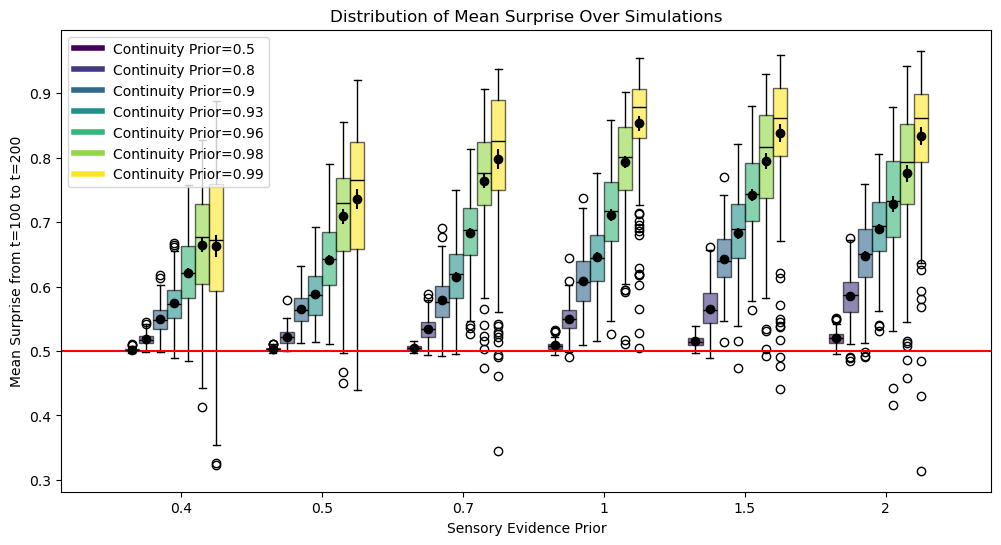

In [50]:
total_biased_trace_expectation = np.sum(m_expectations_MN[:,:,:,:,[x for x in range(num_m_nodes) if x % 2 == 0]], axis = 4) #sum over memory traces encoded during biased coin flips
mean_biased_trace_expectation = np.mean(total_biased_trace_expectation[:, :, :,[x for x in range(100,200) if x % 2 == 0]], axis = 3) #average sum of memory trace exictations over all simulations for each parameter set
A = np.shape(mean_biased_trace_expectation)[0] #sensory_evidence_priors
B = np.shape(mean_biased_trace_expectation)[1] #continuity_priors
C = np.shape(mean_biased_trace_expectation)[2] #simulations
# Define colors for B indices
colors = plt.cm.viridis(np.linspace(0, 1, B))  # B distinct colors

# Create box plot
plt.figure(figsize=(12, 6))

for b in range(B):
    box_data_biased = [mean_biased_trace_expectation[a, b, :] for a in range(A)]
    positions = np.arange(A) + (b - B / 2) * 0.1  # Adjust positions to avoid overlap
    plt.boxplot(box_data_biased, positions=positions, widths=0.1, patch_artist=True, 
                boxprops=dict(facecolor=colors[b], alpha=0.6), 
                medianprops=dict(color='black'))
    # Calculate and add 95% credible interval error bars
    for a in range(A):
        mean_val = np.mean(mean_biased_trace_expectation[a, b, :])
        ci_low, ci_high = stats.t.interval(0.95, df=C-1, loc=mean_val, scale=stats.sem(mean_biased_trace_expectation[a, b, :]))
        plt.errorbar(positions[a], mean_val, yerr=[[mean_val - ci_low], [ci_high - mean_val]], fmt='o', color='black')

plt.axhline(y = 0.5, linestyle = "solid", color = 'red')
# Create legend
legend_patches = [plt.Line2D([0], [0], color=colors[b], lw=4, label=f'Continuity Prior={continuity_priors[b]}') for b in range(B)]
plt.legend(handles=legend_patches)
plt.title("Distribution of Mean Surprise Over Simulations")
plt.ylabel("Mean Surprise from t=100 to t=200")
plt.xlabel("Sensory Evidence Prior")
plt.xticks(range(A), labels=[f"{sensory_evidence_priors[a]}" for a in range(A)])
plt.show()

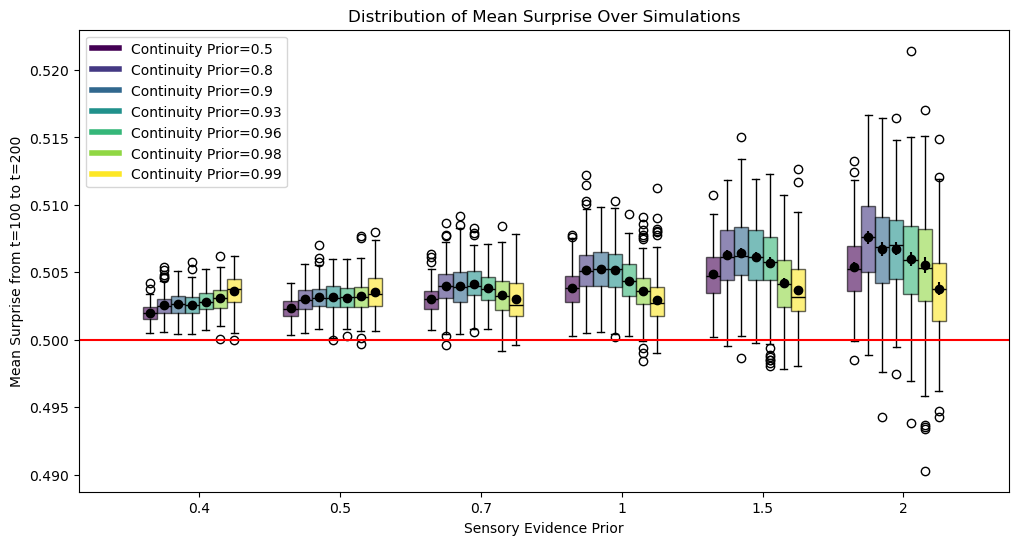

In [47]:
mean_biased_sensory_expectation = np.sum(sensory_expectations_MN[:,:,:,:,:], axis = 3) #average over memory traces encoded during biased coin flips
A = np.shape(mean_biased_sensory_expectation)[0] #sensory_evidence_priors
B = np.shape(mean_biased_sensory_expectation)[1] #continuity_priors
C = np.shape(mean_biased_sensory_expectation)[2] #simulations
# Define colors for B indices
colors = plt.cm.viridis(np.linspace(0, 1, B))  # B distinct colors

# Create box plot
plt.figure(figsize=(12, 6))

for b in range(B):
    box_data_biased = [mean_biased_sensory_expectation[a, b, :] for a in range(A)]
    positions = np.arange(A) + (b - B / 2) * 0.1  # Adjust positions to avoid overlap
    plt.boxplot(box_data_biased, positions=positions, widths=0.1, patch_artist=True, 
                boxprops=dict(facecolor=colors[b], alpha=0.6), 
                medianprops=dict(color='black'))
    # Calculate and add 95% credible interval error bars
    for a in range(A):
        mean_val = np.mean(mean_biased_trace_expectation[a, b, :])
        ci_low, ci_high = stats.t.interval(0.95, df=C-1, loc=mean_val, scale=stats.sem(mean_biased_trace_expectation[a, b, :]))
        plt.errorbar(positions[a], mean_val, yerr=[[mean_val - ci_low], [ci_high - mean_val]], fmt='o', color='black')

plt.axhline(y = 0.5, linestyle = "solid", color = 'red')
# Create legend
legend_patches = [plt.Line2D([0], [0], color=colors[b], lw=4, label=f'Continuity Prior={continuity_priors[b]}') for b in range(B)]
plt.legend(handles=legend_patches)
plt.title("Distribution of Mean Surprise Over Simulations")
plt.ylabel("Mean Surprise from t=100 to t=200")
plt.xlabel("Sensory Evidence Prior")
plt.xticks(range(A), labels=[f"{sensory_evidence_priors[a]}" for a in range(A)])
plt.show()

We can see that the network improves its ability to make predictions as it gather sensory samples from them environment and encodes them to its episodic memory. It also is able to make 

In [37]:
def plot_heatmap(matrix, title="Heatmap", xlabel="Columns", ylabel="Rows", color="Blues"):
    """
    Plots a heatmap of the given matrix using the intensity of a single color.
    
    :param matrix: 2D numpy array to be visualized.
    :param title: Title of the heatmap.
    :param xlabel: Label for the x-axis.
    :param ylabel: Label for the y-axis.
    :param color: The base color for intensity visualization.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap=plt.colormaps.get_cmap(color), aspect='auto')
    plt.colorbar(label="Intensity")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

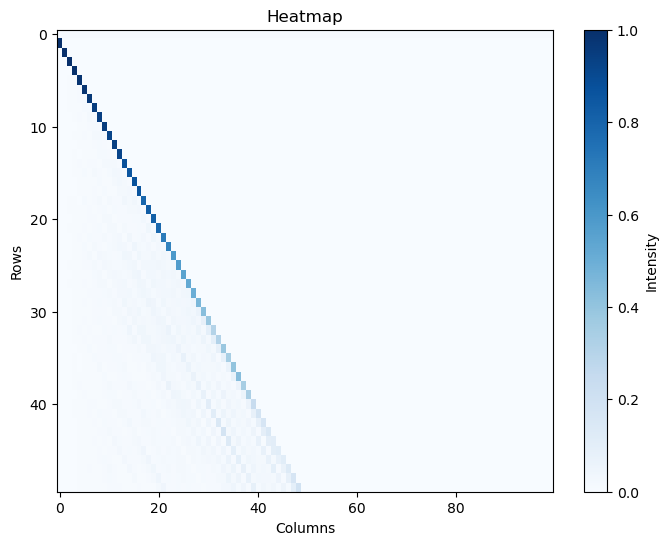

In [46]:
plot_heatmap(m_expectations_MN[2,3,5,0:50,:])

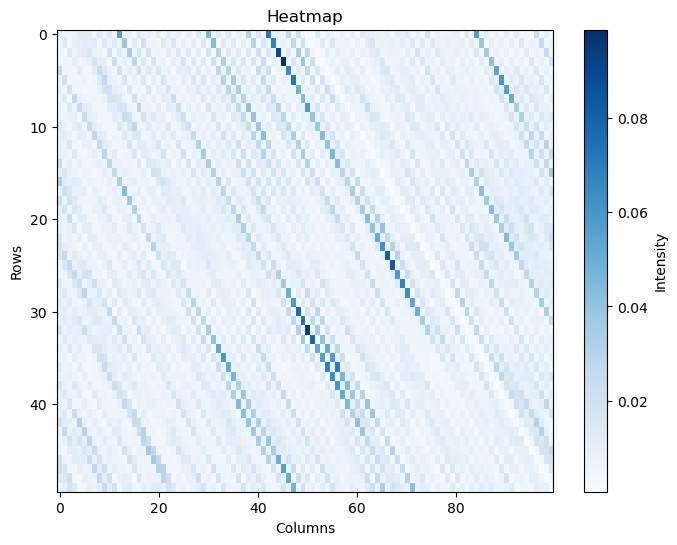

In [53]:
plot_heatmap(m_expectations_MN[2,3,5,150:200,:])

In [ ]:
memory_net.C_matrix

In [54]:
#Set up Variables
N = 200
T = 200
sensory_evidence_priors = (0.4,0.5,0.7,1,1.5,2)
continuity_priors = (0.5,0.8, 0.9, 0.93, 0.96, 0.98, 0.99)
num_sensory_elements = 2
num_m_nodes = 100
probabilities = np.array(([0.95,0.5],[0.1,0.5]))
transitions = np.array(([0,1],[1,0]))
env_state = 0
"""
Run N simulations for T iterations, storing the surprise values and m_expectations.
"""
surprise_data_MN2 = np.zeros((len(sensory_evidence_priors), len(continuity_priors), N, T))
m_expectations_MN2 = np.zeros((len(sensory_evidence_priors), len(continuity_priors),N,T,num_m_nodes))
sensory_expectations_MN2 = np.zeros((len(sensory_evidence_priors), len(continuity_priors),N,T,num_sensory_elements))

for i in range(len(sensory_evidence_priors)):
    for j in range(len(continuity_priors)):
        for n in range(N):
            # Initialize Bayesian Network and Flip Generator for each simulation
            memory_net = Bayesian_Memory(num_sensory_elements, num_m_nodes, sensory_evidence_prior = sensory_evidence_priors[i], continuity_prior = continuity_priors[j])
            flip_gen = flip_generator(probabilities, transitions, env_state)
            
            for t in range(T):
                # Generate percept input using flip generator
                percept = flip_gen.generate()
                
                # Run Bayesian network methods in sequence
                m_expectations_MN2[i,j,n,t,:] = memory_net.m_expectation
                sensory_expectations_MN2[i,j,n,t,:] = memory_net.sensory_expectation
                memory_net.excite_network(percept)
                memory_net.encode_memory()
                surprise_data_MN2[i,j,n,t] = memory_net.get_surprise()
                memory_net.activate()
                memory_net.set_expectations()
                

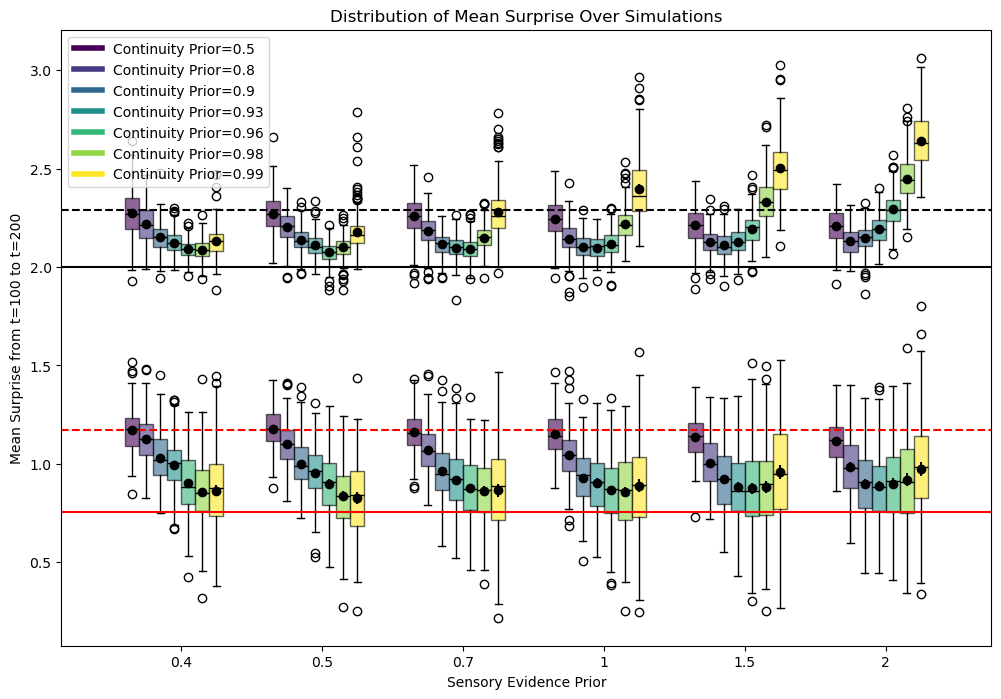

In [56]:
mean_biased_state_surprise = np.mean(surprise_data_MN2[:,:,:,[x for x in range(100,T) if x % 2 == 0]], axis = 3)
mean_fair_state_surprise = np.mean(surprise_data_MN2[:,:,:,[x for x in range(100,T) if x % 2 == 1]], axis = 3)

A = np.shape(mean_biased_state_surprise)[0] #sensory_evidence_priors
B = np.shape(mean_biased_state_surprise)[1] #continuity_priors
C = np.shape(mean_biased_state_surprise)[2] #simulations
# Define colors for B indices
colors = plt.cm.viridis(np.linspace(0, 1, B))  # B distinct colors

# Create box plot
plt.figure(figsize=(12, 8))

for b in range(B):
    box_data_biased = [mean_biased_state_surprise[a, b, :] for a in range(A)]
    positions = np.arange(A) + (b - B / 2) * 0.1  # Adjust positions to avoid overlap
    plt.boxplot(box_data_biased, positions=positions, widths=0.1, patch_artist=True, 
                boxprops=dict(facecolor=colors[b], alpha=0.6), 
                medianprops=dict(color='black'))
    # Calculate and add 95% credible interval error bars
    for a in range(A):
        mean_val = np.mean(mean_biased_state_surprise[a, b, :])
        ci_low, ci_high = stats.t.interval(0.95, df=C-1, loc=mean_val, scale=stats.sem(mean_biased_state_surprise[a, b, :]))
        plt.errorbar(positions[a], mean_val, yerr=[[mean_val - ci_low], [ci_high - mean_val]], fmt='o', color='black')

    box_data_fair = [mean_fair_state_surprise[a, b, :] for a in range(A)]
    positions = np.arange(A) + (b - B / 2) * 0.1 # Adjust positions to avoid overlap
    plt.boxplot(box_data_fair, positions=positions, widths=0.1, patch_artist=True, 
                boxprops=dict(facecolor=colors[b], alpha=0.6), 
                medianprops=dict(color='black'))

    # Calculate and add 95% credible interval error bars
    for a in range(A):
        mean_val = np.mean(mean_fair_state_surprise[a, b, :])
        ci_low, ci_high = stats.t.interval(0.95, df=C-1, loc=mean_val, scale=stats.sem(mean_fair_state_surprise[a, b, :]))
        plt.errorbar(positions[a], mean_val, yerr=[[mean_val - ci_low], [ci_high - mean_val]], fmt='o', color='black')

biased_coin_entropy = -(0.95 * np.log2(0.95) + 0.05 * np.log2(0.05)) - (0.1 * np.log2(0.1) + 0.9 * np.log2(0.9))
one_state_surprise_bias = -(0.95 * np.log2(0.725) + 0.05 * np.log2(0.275)) - (0.1 * np.log2(0.3) + 0.9 * np.log2(0.7))
one_state_surprise_fair = -(0.5 * np.log2(0.725) + 0.5 * np.log2(0.275)) - (0.5 * np.log2(0.3) + 0.5 * np.log2(0.7))

plt.axhline(y = biased_coin_entropy, label = "biased coin entropy", linestyle = "solid", color = 'red')
plt.axhline(y = one_state_surprise_bias, label = "one_state_surprise", linestyle = "dashed", color = 'red')
plt.axhline(y = 2, label = "fair coin entropy", linestyle = "solid", color = 'black')
plt.axhline(y = one_state_surprise_fair, linestyle = "dashed", color = 'black')
# Create legend
legend_patches = [plt.Line2D([0], [0], color=colors[b], lw=4, label=f'Continuity Prior={continuity_priors[b]}') for b in range(B)]
plt.legend(handles=legend_patches, loc = 0)
plt.title("Distribution of Mean Surprise Over Simulations")
plt.ylabel("Mean Surprise from t=100 to t=200")
plt.xlabel("Sensory Evidence Prior")
plt.xticks(range(A), labels=[f"{sensory_evidence_priors[a]}" for a in range(A)])
plt.show()

By itself, this approach is not going to do a good job of approximating the true system; the traces are not connected to sensory elements with weights that resemble the true observation probabilites of the system and we have not devised a way to fix this. Before we consider approaches to address this issue, let us consider a different example for which the established system *per se* can usefully approximate a fixed-state model of the true system. Now let's say we have a system where in one state the quarter, and only the quarter, always comes up heads. In the other state, the nickel, and only the nickel, always comes up heads. When in the first state, there is a 30% chance of changing states after the flip; in the second state there is a 20% chance of changing states after the flip. In this system, the agent's sensory state can be described by a Markov Process, i.e. the probability distribution over the agent's possible next sensory states depends only on its current sensory state. Though an agent that possesses only a Bayesian Memory Network for its mental model does not initially know the transition probalities between these states, it's *intrinsic bais* for setting edge weights very close to 0 or 1 means the activation of memory traces will depend strongly on its sensory state. Because its sensory state is strongly (indeed, perfectly) indicative of the true world state, the memory traces will act like samples from the true distribution of transitions. Memory trace activation will thus become primarily divided between 

In [ ]:
from projective_simulation.agents import Situated_Agent
from projective_simulation.environments import Timed_Response, Delayed_Response
from projective_simulation.ECMs import Active_Inference_Memory_Network
from projective_simulation.methods.preprocessors import action_factorizor
import nbdev
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
ECM = Active_Inference_Memory_Network(num_actions = 3, N_traces = 200, intrinsic_sensory_expectations = np.array([2]), gnosticism = 2) #we give the agent a single intrisic expectation. An agent preprocessor must be set up to appropriately connect this expectation to the correct sensory state
test_SiPS = Situated_Agent(num_actions = 3, reflex_softmax = 2, ECM = ECM, percept_processor = action_factorizor(percept_dict = {"1": {"1": 3}}, num_actions = 3))
test_env = Delayed_Response(W = 1, N = 2, max_trial_length=2)

trial_num = 0
reward_attained = False
total_trials = 100
action = None
trial_data = np.empty(shape = (total_trials,4)) #each trial, will collect the presented stimulus, the selected action, the trial length, and wether the reward was attained

In [ ]:
if test_env.state["trial_time"] == 0: #check if new trial
    trial_data[trial_num,0] = test_env.state["current_stimulus"] #record which stimulus the agent was presented with

print(test_env.state)
print("beliefs")
print(test_SiPS.ECM.trace_expectations[0:20])
print("expectations")
print(test_SiPS.ECM.percept_expectations)

observation = test_env.get_observation()
action = test_SiPS.get_action(observation)
print("Action: " + str(action))
#check if agent acted after wait period to collect data
if test_env.state["trial_time"] >= test_env.W and not action == 0: 
    trial_data[trial_num,1] = action
    trial_data[trial_num,2] = test_env.state["trial_time"]
    trial_data[trial_num,3] = test_env.state["rewarded_action"] == action

test_env.transition(action)
#if transition starts new trial, increase counter (ends experiment if final trial)
if test_env.state["trial_time"] == 0: #check if new trial
    trial_num += 1

print("excitations")
print(test_SiPS.ECM.trace_excitations[0:20])
print("activations")
print(test_SiPS.ECM.trace_activations[0:20])

In [ ]:
test_SiPS.ECM.W

In [ ]:
test_SiPS.ECM.memory_valences

In [ ]:
while trial_num < total_trials:
    
    if test_env.state["trial_time"] == 0: #check if new trial
        trial_data[trial_num,0] = test_env.state["current_stimulus"] #record which stimulus the agent was presented with
        
    observation = test_env.get_observation()
    action = test_SiPS.get_action(observation)
    #check if agent acted after wait period to collect data
    if test_env.state["trial_time"] >= test_env.W and not action == 0: 
        trial_data[trial_num,1] = action
        trial_data[trial_num,2] = test_env.state["trial_time"]
        trial_data[trial_num,3] = test_env.state["rewarded_action"] == action

    test_env.transition(action)
    #if transition starts new trial, increase counter (ends experiment if final trial)
    if test_env.state["trial_time"] == 0: #check if new trial
        print("trial " + str(trial_num) + " results: " + str(trial_data[trial_num,0:]))
        trial_num += 1

In [ ]:
ECM = Active_Inference_Memory_Network(num_actions = 2, simulation_determinism = 5, kappa = 4, N_traces = 40, intrinsic_sensory_expectations = np.array([3]), gnosticism = 1) #we give the agent a single intrisic expectation. An agent preprocessor must be set up to appropriately connect this expectation to the correct sensory state
test_SiPS = Situated_Agent(num_actions = 2, reflex_softmax = 5, ECM = ECM, percept_processor = action_factorizor(percept_dict = {"1": {"1": 2}}, num_actions = 2))
test_env = Timed_Response(delay = 1)

T = 400
t = 0
data = np.full(shape = (T,2), fill_value = None)


In [ ]:
print(np.round(test_SiPS.ECM.trace_expectations, decimals = 3))

data[t,0] = test_env.state
observation = test_env.get_observation()
action = test_SiPS.get_action(observation)
data[t,1] = action
test_env.transition(action)
t += 1

print(data[0:t,].transpose())
print(np.round(test_SiPS.ECM.trace_activations, decimals = 3))

In [ ]:
while t < T:
    data[t,0] = test_env.state
    observation = test_env.get_observation()
    action = test_SiPS.get_action(observation)
    data[t,1] = action
    test_env.transition(action)
    t += 1

success = [data[i,0] == 3 for i in range(T)]
plt.plot(range(T), [np.sum(success[max(0,i-11):i+1])/len(success[max(0,i-11):i+1]) for i in range(T)])